# AlexNet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision

In [2]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.layer1 =self.image() 
        self.layer2=self.linear()
        
    def image(self):
        layer=nn.Sequential(  
                        nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4),nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3,stride=2),
                        nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,padding=2),nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3,stride=2),
                        nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,padding=1),nn.ReLU(),
                        nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,padding=1),nn.ReLU(),
                        nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,padding=1),nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3,stride=2))
        return layer
    def linear(self):
        layer=nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(6400,4096),nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(4096,4096),nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(4096,10)
                            )
        return layer
        
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x
            

In [3]:
# get data and transform to tensor
# the original image size is (3,24,24). Using resize to transform(3,224,224)
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Resize(224)])

train_ds=datasets.CIFAR10("./data",train=True,download = True,transform = transform)
train_dl=DataLoader(train_ds,batch_size=256,shuffle = True)
test_ds=datasets.CIFAR10("./data",train=False,download = True,transform = transform)
test_dl=DataLoader(test_ds,batch_size=256,shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


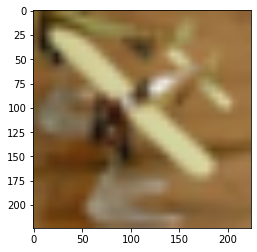

In [4]:
import matplotlib.pyplot as plt
X,y = next(iter(train_dl))
plt.imshow(X[0].detach().numpy().transpose((1, 2, 0)))

In [5]:
def train_one_epoch(model,optimizer,train_dl):
    device = "cuda" if torch.cuda.is_available else "cpu"
    train_loss=0
    for X,y in train_dl:
        model.train()
        X=X.to(device)
        y=y.to(device)
        y_pred = model(X)
        loss = F.cross_entropy(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss +=loss.item() * X.size(0)
        torch.cuda.empty_cache()
    train_loss = train_loss / len(train_dl.dataset)
    return train_loss

def test(model,test_dl):
    device = "cuda" if torch.cuda.is_available else "cpu"
    test_loss=0
    accuracy=0
    for X,y in test_dl:
        X=X.to(device)
        y=y.to(device)
        model.eval()
        y_pred=model(X)
        loss = F.cross_entropy(y_pred,y)
        
        test_loss +=loss.item() * X.size(0)
        accuracy += sum(y_pred.argmax(dim=1) ==y)
        torch.cuda.empty_cache()
    #calculate accuracy and loss
    test_loss = test_loss / len(test_dl.dataset)
    accuracy = accuracy/len(test_dl.dataset)
    return test_loss,accuracy.item()

def train_loop(model,optimizer,train_dl,test_dl,epoch):
    for i in range(epoch):
        train_loss=train_one_epoch(model,optimizer,train_dl)
        test_loss, test_acc= test(model,test_dl)
        print(f"""train loss:{round(train_loss,3)}, test loss: {round(test_loss,3)}, test acc: {round(test_acc,3)}""")

In [6]:
model = AlexNet().cuda()
optimizer=torch.optim.AdamW(model.parameters(),lr=0.0005) 
train_loop(model,optimizer,train_dl,test_dl,10)
optimizer=torch.optim.AdamW(model.parameters(),lr=0.0001) 
train_loop(model,optimizer,train_dl,test_dl,5)

train loss:1.897, test loss: 1.516, test acc: 0.433
train loss:1.375, test loss: 1.191, test acc: 0.568
train loss:1.121, test loss: 1.047, test acc: 0.626
train loss:0.944, test loss: 0.908, test acc: 0.683
train loss:0.813, test loss: 0.805, test acc: 0.719
train loss:0.714, test loss: 0.905, test acc: 0.692
train loss:0.621, test loss: 0.764, test acc: 0.738
train loss:0.542, test loss: 0.749, test acc: 0.748
train loss:0.461, test loss: 0.785, test acc: 0.751
train loss:0.411, test loss: 0.728, test acc: 0.765
train loss:0.237, test loss: 0.709, test acc: 0.797
train loss:0.185, test loss: 0.748, test acc: 0.795
train loss:0.153, test loss: 0.772, test acc: 0.795
train loss:0.127, test loss: 0.843, test acc: 0.797
train loss:0.11, test loss: 0.871, test acc: 0.796


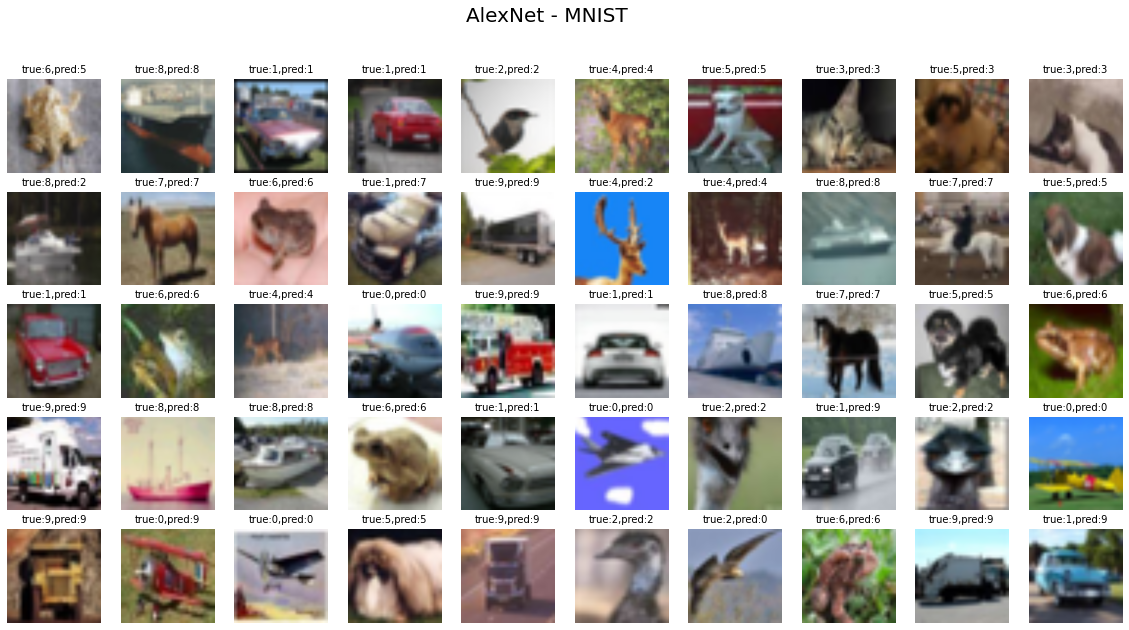

In [8]:
row = 10
col = 5
# get valid data set
valid_x,valid_y=next(iter(test_dl))[:50]
fig = plt.figure(figsize=(20,10))
pred_label=model(valid_x.cuda()).argmax(dim=1)
true_label=valid_y
for i in range(1, row * col + 1):
    plt.subplot(col, row, i)
    plt.axis('off')
    plt.imshow(valid_x[i].detach().numpy().transpose((1, 2, 0)), cmap='gray_r')
    title = f'true:{true_label[i]},pred:{pred_label[i]}'
    plt.title(title, fontsize=10)
fig.suptitle('AlexNet - MNIST',fontsize=20)
plt.savefig("AlexNet_MNIST",facecolor="w")
plt.show()

### Appendix
[Original paper](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)